Updated Working Directory: C:\Users\dvdda\OneDrive\Escritorio\FastApiProjects\pythonProject2
Promedio real de la cantidad de artículos: 80.00888888888889
Promedio estimado mediante Monte Carlo: 79.88310367595258


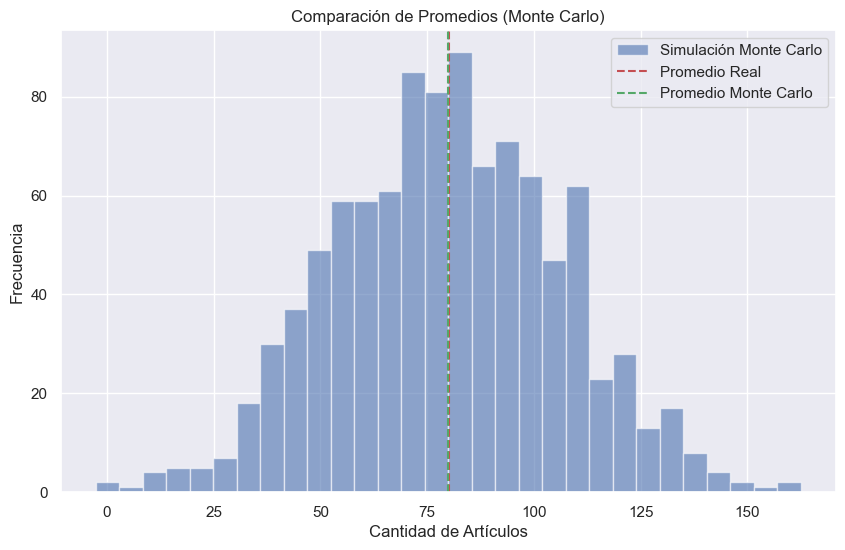

C:\Users\dvdda\AppData\Local\Temp\ipykernel_10680\1550131348.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_vector = [X_canonical.mean()[0], Y_canonical.mean()]


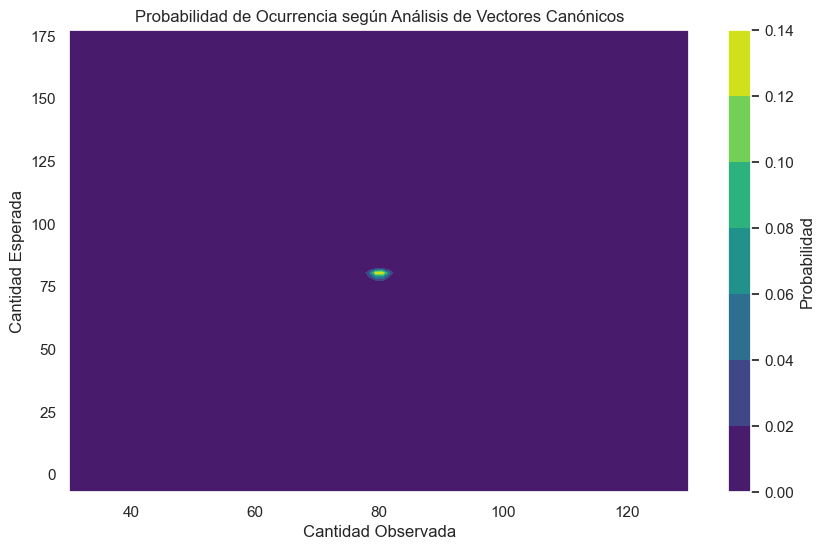

Probabilidad de ocurrencia de la cantidad esperada: 0.15575017291119558


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import CCA
from scipy.stats import multivariate_normal
import os

# Cambia el directorio de trabajo al que contiene el proyecto
os.chdir("C:/Users/dvdda/OneDrive/Escritorio/FastApiProjects/pythonProject2")
print("Updated Working Directory:", os.getcwd())  # Muestra el directorio actual para confirmar el cambio

# Define la ruta al archivo de datos
file_path = 'data/raw/mv_newspapers_articles_202410120953.csv'

# Verifica si el archivo existe
if not os.path.exists(file_path):
    # Si el archivo no existe, imprime un mensaje de error
    print(f"Error: The file '{file_path}' does not exist. Please check the path and try again.")
else:
    # Si el archivo existe, carga los datos en un DataFrame de pandas
    data = pd.read_csv(file_path)
    
    # Asegurar que la columna 'publicate_date' esté en formato de datetime
    data['publicate_date'] = pd.to_datetime(data['publicate_date'])

    # Agregar un índice temporal para la regresión lineal
    data['day'] = (data['publicate_date'] - data['publicate_date'].min()).dt.days

    # --- Paso 1: Simulación Monte Carlo con Modelo de Regresión Lineal ---
    
    # Crear y ajustar el modelo de regresión lineal
    X = data[['day']]
    y = data['amount']
    model = LinearRegression()
    model.fit(X, y)

    # Realizar simulaciones Monte Carlo para la cantidad de artículos
    n_simulations = 1000
    predicted_amounts = []

    for _ in range(n_simulations):
        day = np.random.choice(X['day'])
        day_df = pd.DataFrame([[day]], columns=['day'])  # Convertir a DataFrame para coincidencia de nombres
        predicted_amount = model.predict(day_df)[0] + np.random.normal(0, y.std())
        predicted_amounts.append(predicted_amount)

    # Calcular el promedio de las simulaciones
    monte_carlo_mean = np.mean(predicted_amounts)
    real_mean = y.mean()

    # Comparar resultados
    print("Promedio real de la cantidad de artículos:", real_mean)
    print("Promedio estimado mediante Monte Carlo:", monte_carlo_mean)

    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.hist(predicted_amounts, bins=30, alpha=0.6, color='b', label='Simulación Monte Carlo')
    plt.axvline(real_mean, color='r', linestyle='--', label='Promedio Real')
    plt.axvline(monte_carlo_mean, color='g', linestyle='--', label='Promedio Monte Carlo')
    plt.title('Comparación de Promedios (Monte Carlo)')
    plt.xlabel('Cantidad de Artículos')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.show()

    # --- Paso 2: Análisis de Vectores Canónicos ---

    # Crear datos de referencia para el análisis (cantidades esperadas)
    X_canonical = data[['amount']]
    Y_canonical = np.random.normal(X_canonical.mean(), X_canonical.std(), size=(len(X_canonical), 1))

    # Realizar el Análisis de Correlación Canónica (CCA)
    cca = CCA(n_components=1)
    X_c, Y_c = cca.fit_transform(X_canonical, Y_canonical)

    # Calcular la probabilidad de ocurrencia usando una distribución multivariada
    mean_vector = [X_canonical.mean()[0], Y_canonical.mean()]
    cov_matrix = np.cov(X_c.T, Y_c.T)

    # Calcular probabilidades para un rango de valores
    x_range = np.linspace(X_canonical.min(), X_canonical.max(), 100).flatten()
    y_range = np.linspace(Y_canonical.min(), Y_canonical.max(), 100).flatten()
    X_grid, Y_grid = np.meshgrid(x_range, y_range)
    pos = np.dstack((X_grid, Y_grid))
    rv = multivariate_normal(mean_vector, cov_matrix)

    # Graficar la distribución de probabilidad
    plt.figure(figsize=(10, 6))
    plt.contourf(X_grid, Y_grid, rv.pdf(pos), cmap='viridis')
    plt.title('Probabilidad de Ocurrencia según Análisis de Vectores Canónicos')
    plt.xlabel('Cantidad Observada')
    plt.ylabel('Cantidad Esperada')
    plt.colorbar(label='Probabilidad')
    plt.show()

    # Interpretar resultados
    predicted_prob = rv.pdf([real_mean, monte_carlo_mean])
    print("Probabilidad de ocurrencia de la cantidad esperada:", predicted_prob)

